In [1]:
import sys
sys.path.append("..")

from utils import *

import numpy as np
import gpflow

import matplotlib.pyplot as plt
import gpflow.multioutput.kernels as mk
import gpflow.multioutput.features as mf
import os, sys

from MixtureSVGP import MixtureSVGP, generate_updates
import tensorflow as tf
import pickle

import seaborn as sns

from model_analysis import *

## Description of model

A clustering of genes and cell lines was learned from the gene expression data. The goal was that cell lines within a cell line cluster would exhibit similar global gene expression profiles and that genes within a gene cluster would exhibit similar expression trajectories.


## Periodic trajectories

We found that a number of learned gene cluster trajectories exhibit periodic behavior. Can these patterns be explained by some aspect of the differentiation experiment protocol/ do you have any insight into what could be driving these expression patterns?

Some examples of periodic trajectories are shown below where we learned 50 gene clusters. Below that are tables reporting significant enrichment of these gene clusters with Hallmark and GO gene sets. 

In [2]:
model_path = '../output/models/mixsvgp_K2_L50_0_28542823'
model_name = model_path.split('/')[-1]
params, assignments, logger, likelihood_hist, kernel_hist, assignment_hist = pickle.load(open(model_path, 'rb'))

N, K = assignments.Phi.shape
G, L = assignments.Lambda.shape

In [3]:
m = reload_model(assignments, params, 'shared')
m.assign(params)

In [4]:
def plot_trajectories(m, assignments, active_gene_clusters=None, feed_dict={}):
    if active_gene_clusters is None:
        active_gene_clusters = np.arange(assignments.Lambda.shape[1])

    x, y, X, Y, weight_idx = pickle.load(
        open('../data/ipsc_data_pickle', 'rb'))

    N, K = assignments.Phi.shape
    G, L = assignments.Lambda.shape

    pX = np.linspace(0, 15, 100)[:, None]
    fm, fV = m.predict_f(pX, feed_dict=feed_dict)
    fm = fm.reshape(-1, K, L)
    fV = fV.reshape(-1, K, L)
    for l in active_gene_clusters:
        for k in range(K):
            plt.plot(pX, fm[:, k, l])
            top = fm[:, k, l] + 2.0 * fV[:, k, l] ** 0.5
            bot = fm[:, k, l] - 2.0 * fV[:, k, l] ** 0.5
            plt.fill_between(pX[:, 0], top, bot, alpha=0.3)
        plt.suptitle('gene_clusger_id:' + str(l) + ', ' + 'num_genes:' + str(np.bincount(assignments.Lambda.argmax(1))[l]))
        #plt.ylim([-2, 2])
        plt.grid()
        plt.show()
        
def plot_trajectories2(m, assignments, active_gene_clusters=None, feed_dict={}):
    if active_gene_clusters is None:
        active_gene_clusters = np.arange(assignments.Lambda.shape[1])

    x, y, X, Y, weight_idx = pickle.load(
        open('../data/ipsc_data_pickle', 'rb'))

    N, K = assignments.Phi.shape
    G, L = assignments.Lambda.shape

    pX = np.linspace(0, 15, 100)[:, None]
    fm, fV = m.predict_f(pX, feed_dict=feed_dict)
    fm = fm.reshape(-1, K, L)
    fV = fV.reshape(-1, K, L)
    lines = ["-","--","-.",":"]
    palette = sns.color_palette()
    for i, l in enumerate(active_gene_clusters):
        for k in range(K):
            plt.plot(pX, fm[:, k, l], ls=lines[k], c=palette[i], label='l' + str(l) + '_k' + str(k))
        #plt.ylim([-2, 2])
    plt.grid()
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(active)
    plt.show()

## Examples of periodic trajectories

Each plot gives a gene cluster with periodic trajectories.

Color indicates cell-line cluster.
Plotted are the mean trajectories with shaded regions +- 2 standard deviations

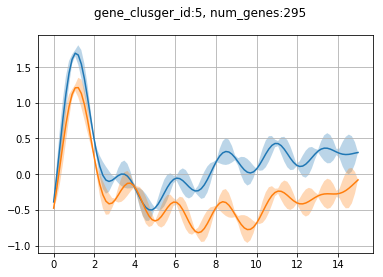

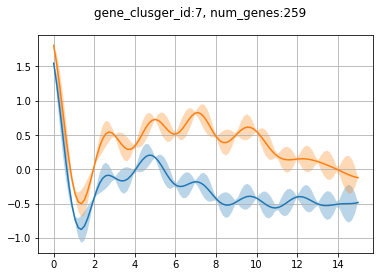

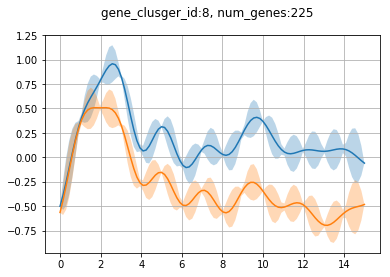

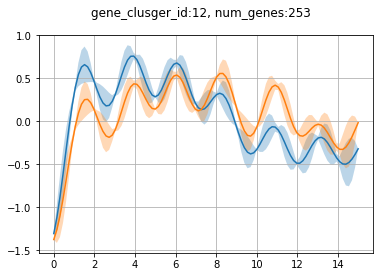

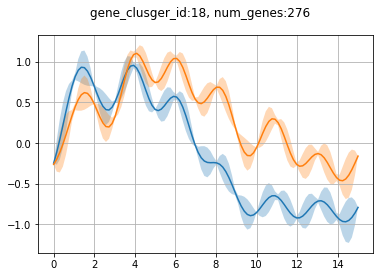

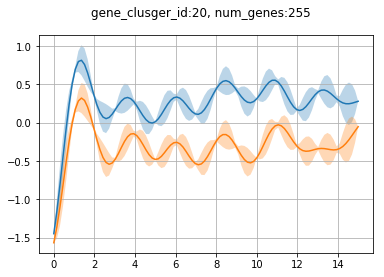

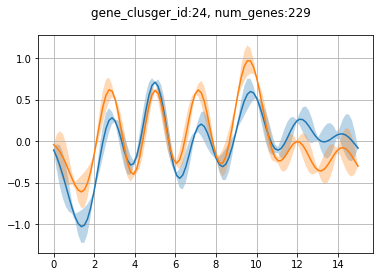

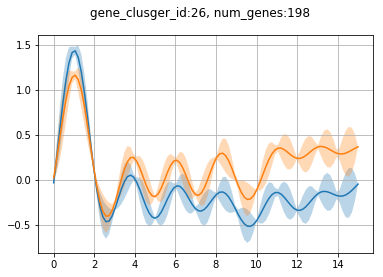

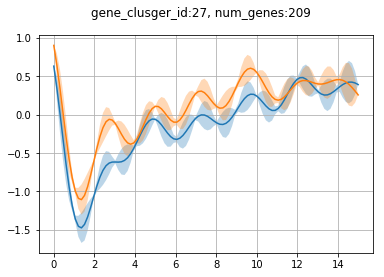

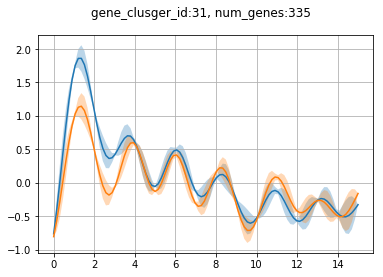

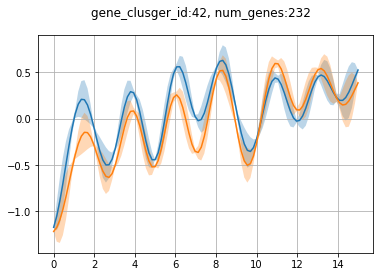

In [15]:
active=[5, 7, 8, 12, 18, 20, 24, 26, 27, 31, 42]
plot_trajectories(m, assignments, active, {})

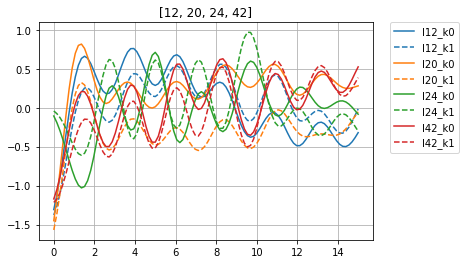

In [11]:
active=[12, 20,24, 42]
plot_trajectories2(m, assignments, active, {})

## Hallmark enrichments

In [16]:
pickle_path = '../output/enrichments/hallamrk/' + model_name + 'hallmark_enrichments'
results = gen_gsea_df(assignments, pickle_path, threshold=1e-2)

idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[active, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[active, 'bonferonni-adjusted']]

,5,18,42
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
HALLMARK_MITOTIC_SPINDLE,1,0.00488074,1
HALLMARK_G2M_CHECKPOINT,1,7.35483e-14,1
HALLMARK_PI3K_AKT_MTOR_SIGNALING,1,1,0.00449505
HALLMARK_E2F_TARGETS,1,4.72663e-09,1
HALLMARK_MYC_TARGETS_V1,1,6.19825e-10,1
HALLMARK_OXIDATIVE_PHOSPHORYLATION,2.69706e-13,1,1


## GO Biological processes Enrichments

Column labels indicate the gene cluster id. Table entries are bonferonni adjusted p-values

In [17]:
gene_set_path='../../gsea/data/c5.bp.v5.1.symbols.gmt.txt'
pickle_path = '../output/enrichments/hallamrk/' + model_name + 'go_bp_enrichments'
results = gen_gsea_df(assignments, pickle_path, gene_set_path, threshold=1e-2)

idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[active, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[active, 'bonferonni-adjusted']]

,18,31
,bonferonni-adjusted,bonferonni-adjusted
RNA_METABOLIC_PROCESS,1.99961e-08,0.0239949
BIOPOLYMER_METABOLIC_PROCESS,2.863e-05,0.00191786
NUCLEOBASENUCLEOSIDENUCLEOTIDE_AND_NUCLEIC_ACID_METABOLIC_PROCESS,4.60674e-09,0.00177785
POSITIVE_REGULATION_OF_NUCLEOBASENUCLEOSIDENUCLEOTIDE_AND_NUCLEIC_ACID_METABOLIC_PROCESS,0.0055002,1
CELL_CYCLE_PROCESS,0.00171765,1
REGULATION_OF_TRANSCRIPTION_FROM_RNA_POLYMERASE_II_PROMOTER,0.00950706,1
REGULATION_OF_CELLULAR_METABOLIC_PROCESS,0.00104584,1
RNA_PROCESSING,2.45147e-06,0.509499
POSITIVE_REGULATION_OF_METABOLIC_PROCESS,0.00990024,1


## GO Cellular component enrichments

In [18]:
gene_set_path='../../gsea/data/c5.cc.v5.1.symbols.gmt.txt'

pickle_path = '../output/enrichments/hallamrk/' + model_name + 'go_cc_enrichments'
results = gen_gsea_df(assignments, pickle_path, gene_set_path, threshold=1e-2)

idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[active, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[active, 'bonferonni-adjusted']]

,5,7,12,18,27,31
,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted,bonferonni-adjusted
NUCLEOPLASM,1,1,1,0.000488399,1,0.651296
ORGANELLE_PART,1,1,0.109539,7.4421e-06,1,0.941886
MITOCHONDRIAL_PART,0.00653493,1,1,1,1,1
RIBONUCLEOPROTEIN_COMPLEX,1,1,0.0020745,0.0249423,1,1
NUCLEAR_PART,1,1,0.000217971,1.50874e-09,1,0.0682333
NUCLEAR_LUMEN,1,1,1,0.00274168,1,0.286123
NON_MEMBRANE_BOUND_ORGANELLE,1,1,1,0.00247909,1,1
NUCLEUS,1,1,0.0004116,2.33499e-13,1,3.41932e-06
INTEGRAL_TO_MEMBRANE,1,0.00808275,1,1,0.0464998,1


## GO Molecular function enrichments

In [19]:
gene_set_path='../../gsea/data/c5.mf.v5.1.symbols.gmt.txt'

pickle_path = '../output/enrichments/hallamrk/' + model_name + 'go_mf_enrichments'
results = gen_gsea_df(assignments, pickle_path, gene_set_path, threshold=1e-2)

idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[active, 'bonferonni-adjusted']]

idx = pd.IndexSlice
active_clusters = np.where(np.any(results.T.loc[:, idx[:, 'bonferonni-adjusted']] < 0.01, axis=0) == 1)[0]
active_results = pd.concat([results.T.iloc[:, results.index.get_level_values(0).get_loc(a)] for a in active_clusters], axis=1)
active_gene_sets = np.where(np.any(active_results.loc[:, idx[active, 'bonferonni-adjusted']] < 0.01, axis=1))[0]
active_results = active_results.iloc[active_gene_sets]
active_results.loc[:, idx[active, 'bonferonni-adjusted']]

,18
,bonferonni-adjusted
RNA_SPLICING_FACTOR_ACTIVITYTRANSESTERIFICATION_MECHANISM,0.00507807
HELICASE_ACTIVITY,0.00514672
